In [2]:
%matplotlib inline
import time
import pickle
import numpy as np
from qiskit import *
from qiskit import IBMQ
import matplotlib.pyplot as plt
from qiskit.tools.monitor import job_monitor
from qiskit.tools.visualization import plot_histogram

date = '04-23-2020-1800'
multiplier = 16
machine = 'ibmq_london'

In [3]:
#Get provider
IBMQ.save_account('f2fcc2d8cff908878030fcb87e40c02f6dfe5cf467c5b948c1ae0b091b0f66b20bb4fc7078fedf45ed6379e336baea7572bee513469a4d4abbfc649ec82f1c16')
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
backend = provider.get_backend(machine)

configrc.store_credentials:WARNING:2020-07-23 10:29:37,857: Credentials already present. Set overwrite=True to overwrite.


In [4]:
#Get identity gate time
backend_properties = backend.properties()
dt = backend_properties._gates['id'][0,]['gate_length'][0] * 1e6

0.03555555555555556


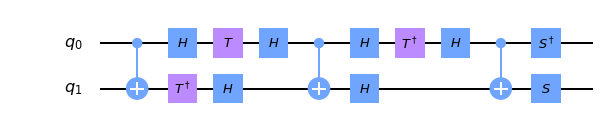

In [4]:
#Define square root SWAP gate
ss_circuit = QuantumCircuit(2, name='Square Root SWAP Gate')
ss_circuit.cx(0,1)
ss_circuit.h(0)
ss_circuit.t(0)
ss_circuit.tdg(1)
ss_circuit.h(0)
ss_circuit.h(1)
ss_circuit.cx(0,1)
ss_circuit.h(0)
ss_circuit.h(1)
ss_circuit.tdg(0)
ss_circuit.h(0)
ss_circuit.cx(0,1)
ss_circuit.sdg(0)
ss_circuit.s(1)

ss = ss_circuit.to_instruction()

ss_circuit.draw(output='mpl')

In [5]:
def ramsey_experiment(minus_state, wait_time):

# initialize quantum circuit
    circuit = QuantumCircuit(2,2)

# qubit 2 rotation of pi along x
    circuit.x(1)

# square root of SWAP circuit
    circuit.append(ss, [0,1])

# qubit 1 rotation of pi/2 along z
    circuit.s(0)

# qubit 2 rotation of pi along x
    circuit.x(1)

# define wait gates
    w_circuit = QuantumCircuit(2, name='Wait Gate: ' + str(round(wait_time * dt, 3)) + 'μs')

    for t in range(wait_time):
        w_circuit.i(0)
        w_circuit.i(1)

    w = w_circuit.to_instruction()

# wait
    circuit.append(w, [0,1])

# qubit 2 rotation of pi along x
    circuit.x(1)

# qubit 1 rotation of -pi/2 along z
    circuit.sdg(0)

# square root of SWAP circuit
    circuit.append(ss, [0,1])

# qubit 2 rotation of pi along x
    circuit.x(1)
    
# measure circuit
    circuit.measure(0, 0)
    circuit.measure(1, 1)
    
    return circuit

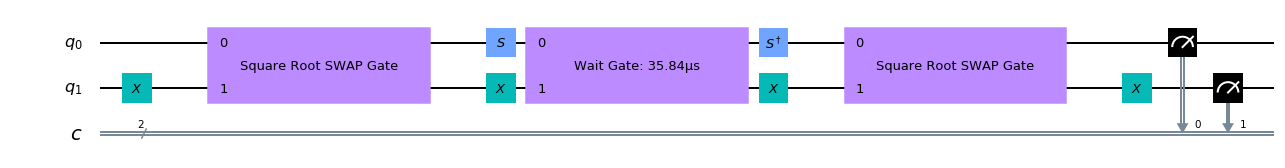

In [6]:
circuits = []
for c in range(64):
    circuits.append(ramsey_experiment(True, c*multiplier))

# print circuit
circuits[63].draw(output='mpl')

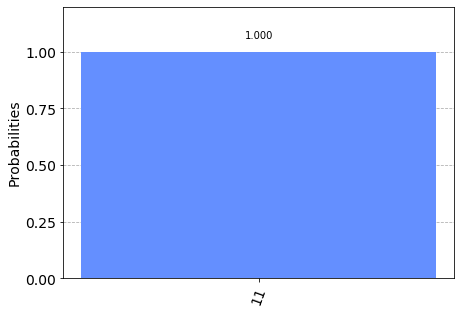

In [7]:
# choose machine to run circuit
simulator = Aer.get_backend('qasm_simulator')

# get results
result = execute(circuits[63], backend = simulator).result()

# plot results
plot_histogram(result.get_counts(circuits[63]))

In [8]:
start_timer = time.time()
results = []
job = execute(circuits, backend, shots=8192, optimization_level=0)

# monitor job
job_monitor(job)
    
# get results
result = job.result()

print(str((time.time()-start_timer)/60.) + 'min')

Job Status: job has successfully run
8.919343582789104min


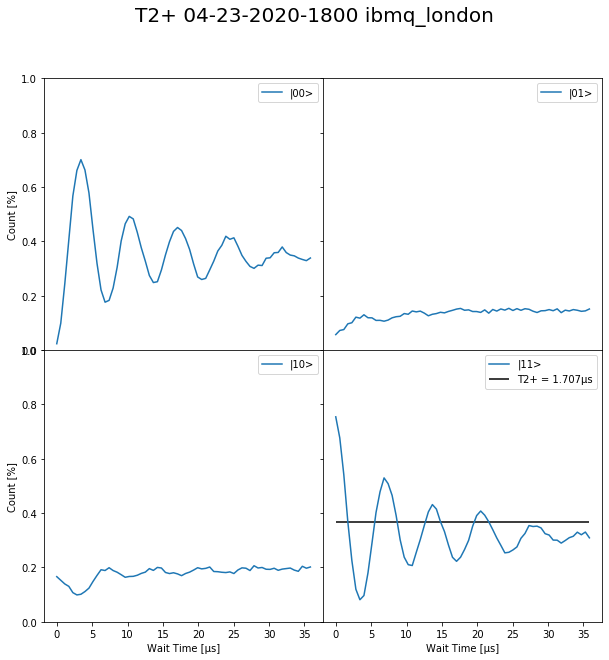

In [9]:
fig, ax = plt.subplots(2, 2, sharex='col', sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0}, figsize=(10,10))
fig.suptitle('T2+ ' + date + ' ' + machine, fontsize=20)

for i in range(2):
    for j in range(2):
        counts = []
        wait_time = []
        for count in range(len(circuits)):
            counts.append(result.get_counts(circuits[count])[str(i) + str(j)] / 8192)
            wait_time.append(dt*count*multiplier)
            
        ax[i,j].plot(wait_time, counts)
        ax[i,j].set_ylim([0, 1])
        if i == 1 and j == 1:
            T_2 = round(wait_time[np.where(np.abs(counts - 1/np.exp(1)) < 5e-2)[0][0]], 3)
            ax[1,1].hlines(1/np.exp(1), wait_time[0], wait_time[-1])
            ax[1,1].legend(['|' + str(i) + str(j) + '>', 'T2+ = ' + str(T_2) + 'μs'])
        else:
            ax[i,j].legend(['|' + str(i) + str(j) + '>'])
            
        if i == 1:
            ax[i,j].set(xlabel='Wait Time [μs]')
        if j == 0:
            ax[i,j].set(ylabel='Count [%]')
        
fig.savefig('T2+' + '_' + date + '_' + machine + '.pdf')

In [10]:
with open('circuits_T2+_' + date + '_' + machine + '.txt', "wb") as fp:   #Pickling
    pickle.dump(circuits, fp)
fp.close()

with open('results_T2+_' + date + '_' + machine + '.txt', "wb") as fp:   #Pickling
    pickle.dump(results, fp)
fp.close()